In [1]:
from langgraph.graph import StateGraph, END
from langgraph.types import interrupt
from typing import TypedDict, Optional, Dict, Any, List,Annotated,Sequence
from langchain_core.messages import BaseMessage,HumanMessage
from agents.youtube_post_agent import generate_youtube_content
from agents.topic_learning_agent import learning_agent
from agents.article_post_agent import article_post_content
from agents.router_agent import router_agent
from langgraph.graph.message import add_messages
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

/home/rohan.dubey@simform.dom/.pyenv/versions/3.9.22/envs/agent-project/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class AgentState(TypedDict):
        query:str
        messages: Annotated[Sequence[BaseMessage], add_messages]
        intermediate_data: Optional[Dict[str, Any]]
        next_node:Optional[str]
        response:Optional[str]

In [3]:
def router_node(state:AgentState)-> AgentState:
        routing_result=router_agent(query=state['query'],chat_history=state.get("messages", []),intermediate_data=state.get("intermediate_data", {}))
        state["query"]=routing_result.get('query',state["query"])
        state["next_node"] = routing_result.get("next_node", "none")
        state["response"] = routing_result["response"]

        for key in routing_result.get("reset_keys", []):
            if key in state["intermediate_data"]:
                state["intermediate_data"][key] = None

        return state

In [4]:
def youtube_content_node(state:AgentState)-> AgentState:
        state['response'],state["intermediate_data['last_summary']"]= generate_youtube_content(query=state['query'],intermediate_data=state.get("intermediate_data", {}))
        return state

In [5]:
def course_finder_node(state:AgentState)-> AgentState:
    state['response']=learning_agent(query=state['query'],intermediate_data=state.get("intermediate_data", {}))
    return state

In [6]:
def article_content_node(state:AgentState)->AgentState:
        state['response']=article_post_content(query=state['query'],summary=state.get(['intermediate_data']["last_summary"],""),intermediate_data=state.get("intermediate_data", {}))
        return state

<>:2: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
<>:2: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
/tmp/ipykernel_242619/1175847547.py:2: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  state['response']=article_post_content(query=state['query'],summary=state.get(['intermediate_data']["last_summary"],""),intermediate_data=state.get("intermediate_data", {}))


In [7]:
def hitl_review_node(state: AgentState) -> AgentState:
        return interrupt(
            HumanMessage(
                content=state["response"]  # Send response to user for review
            )
        )

In [8]:
graph=StateGraph(AgentState)

In [9]:
graph.set_entry_point("Router_Agent")

graph.add_node("Router_Agent",router_node)
graph.add_node("youtube_content",youtube_content_node)
graph.add_node("article_content",article_content_node)
graph.add_node("course_finder",course_finder_node)
graph.add_node("hitl_review", hitl_review_node)

In [10]:
graph.add_conditional_edges(
        source="Router_Agent",
        path=lambda state : state['next_node'],
        path_map={
            "topic_learning_agent":"course_finder",
            "youtube_post_agent":"youtube_content",
            "article_post_agent":"article_content",
            "none":END
        }
    )

In [11]:
# After content generation, route to HITL
graph.add_edge("youtube_content", "hitl_review")
graph.add_edge("article_content", "hitl_review")

# After HITL feedback, route back to Router Agent
graph.add_edge("hitl_review", "Router_Agent")

In [12]:
graph.set_finish_point("course_finder")
graph.set_finish_point("Router_Agent")

In [13]:
sqlite_conn=sqlite3.connect("checkpoint.db",check_same_thread=False)
checkpointer=SqliteSaver(sqlite_conn)

config = {"configurable": {"thread_id": "23"}}

In [14]:
app=graph.compile(checkpointer=checkpointer)

In [6]:
from LangGraph_graph.Graph import GenAIMultiAgentRunner
graph=GenAIMultiAgentRunner()
app=graph.get_app()

In [9]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnablePassthrough(), metadata=None), 'Router_Agent': Node(id='Router_Agent', name='Router_Agent', data=Router_Agent(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'youtube_content': Node(id='youtube_content', name='youtube_content', data=youtube_content(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'article_content': Node(id='article_content', name='article_content', data=article_content(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'course_finder': Node(id='course_finder', name='course_finder', data=course_finder(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'human_review': Node(id='human_review', name='human_review', data=human_review(tags=None, recurse=True, explode_args=False,

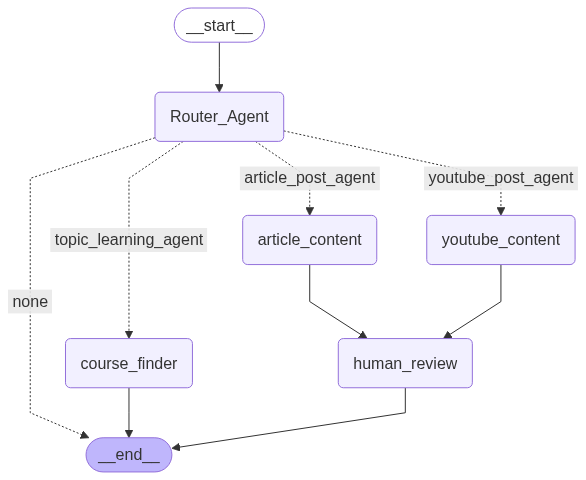

In [10]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [39]:
inputs={"query":"fine me resources for microservice communication"}

In [40]:
result=app.invoke(inputs,config=config)


2025-05-30 11:29:18.593 | INFO     | agents.router_agent:router_agent:18 - query: fine me resources for microservice communication
2025-05-30 11:29:18.596 | INFO     | agents.router_agent:router_agent:23 - prompt entered to router text="You are a multi-agent router responsible for selecting the most suitable agent to handle the user's query. Choose one agent from the list below based on the task described.\n\n    Available Agents:\n    - topic_learning_agent: Fetches learning resources such as YouTube videos, playlists, and online courses based on a topic provided by the user.\n    - youtube_post_agent: Generates social media posts (LinkedIn, Twitter, Reddit) based on the content of a provided YouTube video link.\n    - article_post_agent: Generates social media posts (LinkedIn, Twitter, Reddit) based on the content of a provided web article link.\n\n    Routing Logic:\n    1. If the user provides a **topic they want to learn about**, and is asking for **learning resources**, route to 



> Entering new AgentExecutor chain...


2025-05-30 11:29:20.359 | INFO     | tool.youtube_search_tool:find_youtube_resources:16 - query: microservice communication


Thought: To find learning resources for microservice communication, I should first search for YouTube resources and then search for online courses.

Action: find_youtube_resources
Action Input: microservice communication

2025-05-30 11:29:21.215 | DEBUG    | tool.youtube_search_tool:find_youtube_resources:19 - raw results fetched:{"videos": [{"id": "7IFJb-uLEaI", "thumbnails": ["https://i.ytimg.com/vi/7IFJb-uLEaI/hq720.jpg?sqp=-oaymwEjCOgCEMoBSFryq4qpAxUIARUAAAAAGAElAADIQj0AgKJDeAE=&rs=AOn4CLAt5kZx0R6kpujDY-oOENC13COqMg", "https://i.ytimg.com/vi/7IFJb-uLEaI/hq720.jpg?sqp=-oaymwEXCNAFEJQDSFryq4qpAwkIARUAAIhCGAE=&rs=AOn4CLCkdpF9leOTC-sPFYG0eVTTir75Ow"], "title": "What are MicroServices? When & Why is it used? | Monolithic vs Microservices Architecture", "long_desc": null, "channel": "Apna College", "duration": "9:15", "views": "494,365 views", "publish_time": "1 year ago", "url_suffix": "/watch?v=7IFJb-uLEaI&pp=ygU5bWljcm9zZXJ2aWNlIGNvbW11bmljYXRpb24gY291cnNlIE9SIHR1dG9yaWFsIE9SIHBsYXlsaXN0"}, {"id": "mBNDxpJTg8U", "thumbnails": ["https://i.ytimg.com/vi/mBNDxpJTg8U/hq720.jpg?sqp=-oaymwEjCOgCEMoBSFryq4qpAxUIARUAAAAAGAElAADIQj0AgKJDeAE=&rs=AOn4CLAkRR489bi-eMjiH_pRr7H1rE7YXA", "https://i.ytimg.com/vi/mBNDxpJ


Observation: {"videos": [{"id": "7IFJb-uLEaI", "thumbnails": ["https://i.ytimg.com/vi/7IFJb-uLEaI/hq720.jpg?sqp=-oaymwEjCOgCEMoBSFryq4qpAxUIARUAAAAAGAElAADIQj0AgKJDeAE=&rs=AOn4CLAt5kZx0R6kpujDY-oOENC13COqMg", "https://i.ytimg.com/vi/7IFJb-uLEaI/hq720.jpg?sqp=-oaymwEXCNAFEJQDSFryq4qpAwkIARUAAIhCGAE=&rs=AOn4CLCkdpF9leOTC-sPFYG0eVTTir75Ow"], "title": "What are MicroServices? When & Why is it used? | Monolithic vs Microservices Architecture", "long_desc": null, "channel": "Apna College", "duration": "9:15", "views": "494,365 views", "publish_time": "1 year ago", "url_suffix": "/watch?v=7IFJb-uLEaI&pp=ygU5bWljcm9zZXJ2aWNlIGNvbW11bmljYXRpb24gY291cnNlIE9SIHR1dG9yaWFsIE9SIHBsYXlsaXN0"}, {"id": "mBNDxpJTg8U", "thumbnails": ["https://i.ytimg.com/vi/mBNDxpJTg8U/hq720.jpg?sqp=-oaymwEjCOgCEMoBSFryq4qpAxUIARUAAAAAGAElAADIQj0AgKJDeAE=&rs=AOn4CLAkRR489bi-eMjiH_pRr7H1rE7YXA", "https://i.ytimg.com/vi/mBNDxpJTg8U/hq720.jpg?sqp=-oaymwEXCNAFEJQDSFryq4qpAwkIARUAAIhCGAE=&rs=AOn4CLBae8luqOws4Bmv18AkHkMSObsQQ

KeyboardInterrupt: 

In [40]:
print(result)

{'query': 'what course i was fnding', 'next_node': 'topic_learning_agent', 'response': "Here are the learning resources, including YouTube videos and online courses, with the requested details:\n\n**YouTube Resources:**\n\n1.  **Title:** Free Human Resources (HR) online courses with certificates | LinkedIn Learning\n    *   **Channel Name:** BHAIDI\n    *   **URL:** https://www.youtube.com/watch?v=RIFvqenJdAU\n    *   **Duration:** 4:20\n    *   **Brief description:** Free Human Resources online courses with certificates on LinkedIn Learning\n\n2.  **Title:** SAP MM Full Course 🔥 | Zero to Hero Tutorial for Beginners (2025 Edition)\n    *   **Channel Name:** Accounts Expert\n    *   **URL:** https://www.youtube.com/watch?v=iaD-pyE03lc\n    *   **Duration:** 6:15:00\n    *   **Brief description:** SAP MM Full Course for Beginners\n\n3.  **Title:** Detailed Roadmap for Machine Learning | Free Study Resources | Simply Explained\n    *   **Channel Name:** Apna College\n    *   **URL:** htt

In [41]:
print(result["response"])

Here are the learning resources, including YouTube videos and online courses, with the requested details:

**YouTube Resources:**

1.  **Title:** Free Human Resources (HR) online courses with certificates | LinkedIn Learning
    *   **Channel Name:** BHAIDI
    *   **URL:** https://www.youtube.com/watch?v=RIFvqenJdAU
    *   **Duration:** 4:20
    *   **Brief description:** Free Human Resources online courses with certificates on LinkedIn Learning

2.  **Title:** SAP MM Full Course 🔥 | Zero to Hero Tutorial for Beginners (2025 Edition)
    *   **Channel Name:** Accounts Expert
    *   **URL:** https://www.youtube.com/watch?v=iaD-pyE03lc
    *   **Duration:** 6:15:00
    *   **Brief description:** SAP MM Full Course for Beginners

3.  **Title:** Detailed Roadmap for Machine Learning | Free Study Resources | Simply Explained
    *   **Channel Name:** Apna College
    *   **URL:** https://www.youtube.com/watch?v=1vsmaEfbnoE
    *   **Duration:** 14:59
    *   **Brief description:** Detail

In [42]:
print(app.get_state(config=config))

StateSnapshot(values={'query': 'what course i was fnding', 'next_node': 'topic_learning_agent', 'response': "Here are the learning resources, including YouTube videos and online courses, with the requested details:\n\n**YouTube Resources:**\n\n1.  **Title:** Free Human Resources (HR) online courses with certificates | LinkedIn Learning\n    *   **Channel Name:** BHAIDI\n    *   **URL:** https://www.youtube.com/watch?v=RIFvqenJdAU\n    *   **Duration:** 4:20\n    *   **Brief description:** Free Human Resources online courses with certificates on LinkedIn Learning\n\n2.  **Title:** SAP MM Full Course 🔥 | Zero to Hero Tutorial for Beginners (2025 Edition)\n    *   **Channel Name:** Accounts Expert\n    *   **URL:** https://www.youtube.com/watch?v=iaD-pyE03lc\n    *   **Duration:** 6:15:00\n    *   **Brief description:** SAP MM Full Course for Beginners\n\n3.  **Title:** Detailed Roadmap for Machine Learning | Free Study Resources | Simply Explained\n    *   **Channel Name:** Apna College\

In [43]:
for i in app.get_state_history(config=config):
    print(i)

StateSnapshot(values={'query': 'what course i was fnding', 'next_node': 'topic_learning_agent', 'response': "Here are the learning resources, including YouTube videos and online courses, with the requested details:\n\n**YouTube Resources:**\n\n1.  **Title:** Free Human Resources (HR) online courses with certificates | LinkedIn Learning\n    *   **Channel Name:** BHAIDI\n    *   **URL:** https://www.youtube.com/watch?v=RIFvqenJdAU\n    *   **Duration:** 4:20\n    *   **Brief description:** Free Human Resources online courses with certificates on LinkedIn Learning\n\n2.  **Title:** SAP MM Full Course 🔥 | Zero to Hero Tutorial for Beginners (2025 Edition)\n    *   **Channel Name:** Accounts Expert\n    *   **URL:** https://www.youtube.com/watch?v=iaD-pyE03lc\n    *   **Duration:** 6:15:00\n    *   **Brief description:** SAP MM Full Course for Beginners\n\n3.  **Title:** Detailed Roadmap for Machine Learning | Free Study Resources | Simply Explained\n    *   **Channel Name:** Apna College\